# WebScraping with Selenium

This notebook shows how use selenium to scrape data from Indiegogo.com
The scope is only to understand the capabilities of web scraping and prepare a dataset for academic purporse.


<a href="https://colab.research.google.com/drive/1_WyM24eXWf-pdcqJKCcsb1pWwnbEWRi8?authuser=2#scrollTo=VYfg3I_fSt6e"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


In [ ]:
%%shell
# Ubuntu no longer distributes chromium-browser outside of snap
#
# Proposed solution: https://askubuntu.com/questions/1204571/how-to-install-chromium-without-snap

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

# Install chromium and chromium-driver
apt-get update
apt-get install chromium chromium-driver

# Install selenium
pip install selenium==4.9.1

In [2]:
import sys
import logging
from selenium.webdriver.remote.remote_connection import LOGGER
LOGGER.setLevel(logging.WARNING)
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
from selenium.webdriver.common.by import By
from tqdm import tqdm_notebook as tqdm
import pandas
import json
import pprint

In [3]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument("user-agent=Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36")

In [4]:
wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)

<ipython-input-4-36fd79f00a59>:1: DeprecationWarning: use options instead of chrome_options
  wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)


In [5]:
wd.get("https://www.indiegogo.com/explore/all?project_type=campaign&project_timing=all&sort=trending")

Populating the interactive namespace from numpy and matplotlib


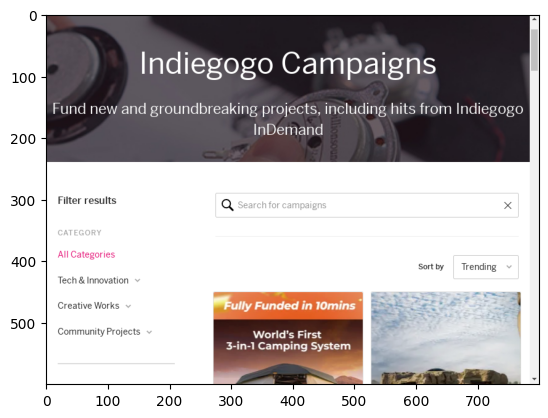

In [6]:
wd.save_screenshot('screenshot.png')

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('/content/screenshot.png')
imgplot = plt.imshow(img)
plt.show()

Let's try to extract some information from the page



`title` contains the title of our page.




In [7]:
print(wd.title)

Explore Crowdfunding Campaigns & Unique Products | Indiegogo


# Project List from Indiegogo

Let's begin to download the list of projects.

The list of projects is defined by the css selection rule
`discoverable-card`



In [8]:
list_projects = wd.find_elements(by=By.CSS_SELECTOR, value="discoverable-card")
print(len(list_projects))

12


Gread! We find 12 project!

Now, we will extract the attribute from each single element.
The scope is to create one dict for each project in the list with the attribute:


1.   url
2.   title
3.   description
4.   category
5.   progress



In [9]:
import pprint
detail_projects = []
for project in list_projects:
    url = project.find_elements(by=By.CSS_SELECTOR, value="a")[0].get_attribute("href")
    title = ""
    description = ""
    category = ""
    project_id = ""
    balance = ""
    currency = ""
    image = ""
    progress = ""
    if(len(project.find_elements(by=By.CSS_SELECTOR, value=".discoverableCard-title")) > 0):
      title = project.find_elements(by=By.CSS_SELECTOR, value=".discoverableCard-title")[0].text
    if(len(project.find_elements(by=By.CSS_SELECTOR, value=".discoverableCard-description")) > 0):
      description = project.find_elements(by=By.CSS_SELECTOR, value=".discoverableCard-description")[0].text
    if(len(project.find_elements(by=By.CSS_SELECTOR, value=".discoverableCard-category")) > 0):
      category = project.find_elements(by=By.CSS_SELECTOR, value=".discoverableCard-category")[0].text
    if(len(project.find_elements(by=By.CSS_SELECTOR, value=".discoverableCard-balance")) > 0):
      balance = project.find_elements(by=By.CSS_SELECTOR, value=".discoverableCard-balance")[0].text
    if(len(project.find_elements(by=By.CSS_SELECTOR, value=".discoverableCard-percent")) > 0):
      progress = project.find_elements(by=By.CSS_SELECTOR, value=".discoverableCard-percent")[0].text
    if(len(project.find_elements(by=By.CSS_SELECTOR, value=".discoverableCard-unitsRaised")) > 0):
      currency = project.find_elements(by=By.CSS_SELECTOR, value=".discoverableCard-unitsRaised")[0].text
    project_id = url
    if(len(project.find_elements(by=By.CSS_SELECTOR, value=".discoverableCard-image")) > 0):
      image = project.find_elements(by=By.CSS_SELECTOR, value=".discoverableCard-image")[0].get_attribute("data-bgset")

    detail_projects.append({'url': url,
                            'image': image,
                            'title': title,
                            'description': description,
                            'category': category,
                            'balance': balance,
                            'currency': currency,
                            'progress': progress,
                            'project_id': project_id})

len(detail_projects)
pprint.pprint(detail_projects[0:5])

[{'balance': '$525,539 ',
  'category': 'TRAVEL & OUTDOORS',
  'currency': 'USD raised',
  'description': 'Ultra durable & weatherproof tent, expedition-grade 6-inch '
                 'Air Floor & temperature-adjusting canopy',
  'image': 'https://c1.iggcdn.com/indiegogo-media-prod-cld/image/upload/c_fill,f_auto,h_273,w_273/zdwroevdfvgnxavddbdm.jpg',
  'progress': '2,102%',
  'project_id': 'https://www.indiegogo.com/projects/space-acacia-world-s-first-3-in-1-camping-system/pica',
  'title': "Space Acacia -World's First 3-In-1 Camping System",
  'url': 'https://www.indiegogo.com/projects/space-acacia-world-s-first-3-in-1-camping-system/pica'},
 {'balance': '$859,763 ',
  'category': 'TRAVEL & OUTDOORS',
  'currency': 'USD raised',
  'description': 'An Ancient-Future Lodging Experience on a 240-Acre Playa',
  'image': 'https://c1.iggcdn.com/indiegogo-media-prod-cld/image/upload/c_fill,f_auto,h_273,w_273/zrjkecda1yt3o1xc2whc.jpg',
  'progress': '8,598%',
  'project_id': 'https://www.indi

Now let's try downloading all the ads on the front page...
and then move on to the second.

First we define a `parse_project` function to make the code cleaner and to reuse the function.

In [10]:
def parse_project(project):
  url = project.find_elements(by=By.CSS_SELECTOR, value="a")[0].get_attribute("href")
  title = ""
  description = ""
  category = ""
  project_id = ""
  balance = ""
  currency = ""
  progress = ""
  image = ""
  try:
    if(len(project.find_elements(by=By.CSS_SELECTOR, value=".discoverableCard-title")) > 0):
      title = project.find_elements(by=By.CSS_SELECTOR, value=".discoverableCard-title")[0].text
    if(len(project.find_elements(by=By.CSS_SELECTOR, value=".discoverableCard-description")) > 0):
      description = project.find_elements(by=By.CSS_SELECTOR, value=".discoverableCard-description")[0].text
    if(len(project.find_elements(by=By.CSS_SELECTOR, value=".discoverableCard-category")) > 0):
      category = project.find_elements(by=By.CSS_SELECTOR, value=".discoverableCard-category")[0].text
    if(len(project.find_elements(by=By.CSS_SELECTOR, value=".discoverableCard-balance")) > 0):
      balance = project.find_elements(by=By.CSS_SELECTOR, value=".discoverableCard-balance")[0].text
    if(len(project.find_elements(by=By.CSS_SELECTOR, value=".discoverableCard-percent")) > 0):
      progress = project.find_elements(by=By.CSS_SELECTOR, value=".discoverableCard-percent")[0].text
    if(len(project.find_elements(by=By.CSS_SELECTOR, value=".discoverableCard-unitsRaised")) > 0):
      currency = project.find_elements(by=By.CSS_SELECTOR, value=".discoverableCard-unitsRaised")[0].text
    if(len(project.find_elements(by=By.CSS_SELECTOR, value=".discoverableCard-image")) > 0):
      image = project.find_elements(by=By.CSS_SELECTOR, value=".discoverableCard-image")[0].get_attribute("data-bgset")
    project_id = url
  except:
    pass
  return {'url': url,
          'title': title,
          'image': image,
          'description': description,
          'category': category,
          'balance': balance,
          'currency': currency,
          'progress': progress,
          'project_id': project_id}


Here's how to download the first page of projects...

In [11]:
detail_projects = []
wd.get("https://www.indiegogo.com/explore/all?project_type=campaign&project_timing=all&sort=trending")
wd.save_screenshot(f'screenshot.png')
list_projects = wd.find_elements(by=By.CSS_SELECTOR, value="discoverable-card")
for project in tqdm(list_projects):
  detail_projects.append(parse_project(project))

print(len(detail_projects))

<ipython-input-11-1e167d0d1737>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for project in tqdm(list_projects):


  0%|          | 0/12 [00:00<?, ?it/s]

12


### How to end scraping?
Problem: When do we stop?





In [16]:
import time
detail_projects = []
wd.get("https://www.indiegogo.com/explore/all?project_type=campaign&project_timing=all&sort=trending")
time.sleep(5)
wd.save_screenshot("check_browser.png")
if (len(wd.find_elements(By.CSS_SELECTOR, "CybotCookiebotDialogBodyButtonAccept")) > 0):
  print("Click cookie law button")
  wd.find_elements(By.CSS_SELECTOR,"CybotCookiebotDialogBodyButtonAccept")[0].click()
for num in tqdm(range(1,10)):
  items = (num - 1) * 12
  list_projects = wd.find_elements(by=By.CSS_SELECTOR, value=f"discoverable-card:nth-child(n+{items})")
  for project in list_projects:
    detail_projects.append(parse_project(project))
  if (len(wd.find_elements(by=By.CSS_SELECTOR, value=".i-cta-1")) > 0):
    wd.find_elements(By.CSS_SELECTOR, ".i-cta-1")[0].click()
    time.sleep(3)
    wd.save_screenshot("check_browser.png")
  else:
    break



<ipython-input-16-76ac09bd5c80>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num in tqdm(range(1,10)):


  0%|          | 0/9 [00:00<?, ?it/s]

In [17]:
print(len(detail_projects))
print(detail_projects[30:32])

116
[{'url': 'https://www.indiegogo.com/projects/glow-haircare-the-first-cordless-hot-air-styler/pica', 'title': 'Glow HairCare -The First Cordless Hot Air Styler', 'image': 'https://c1.iggcdn.com/indiegogo-media-prod-cld/image/upload/c_fill,f_auto,h_273,w_273/sd7efrpdatsgku7qje5q.jpg', 'description': 'Fully Cordless | One Hand Styling | Heated Hair Blowing | Deep Scalp Massager | Advanced Ionic Tech', 'category': 'HEALTH & FITNESS', 'balance': '$606,565 ', 'currency': 'HKD raised', 'progress': '2,015%', 'project_id': 'https://www.indiegogo.com/projects/glow-haircare-the-first-cordless-hot-air-styler/pica'}, {'url': 'https://www.indiegogo.com/projects/loop-dreams-from-dj-to-doctor/pica', 'title': 'Loop Dreams: From DJ to Doctor', 'image': 'https://c1.iggcdn.com/indiegogo-media-prod-cld/image/upload/c_fill,f_auto,h_273,w_273/ygmdjnli84yazfqarq2v.jpg', 'description': 'A fundraising campaign to fund a 3-4 year documentary about my journey through a Ph.D. program.', 'category': 'FILM', 'ba

In [18]:
import pandas as pd
ds_detail_projects = pd.DataFrame(detail_projects)
ds_detail_projects.set_index("project_id")
ds_detail_projects.head()

,url,title,image,description,category,balance,currency,progress,project_id
0,https://www.indiegogo.com/projects/space-acaci...,Space Acacia -World's First 3-In-1 Camping System,https://c1.iggcdn.com/indiegogo-media-prod-cld...,"Ultra durable & weatherproof tent, expedition-...",TRAVEL & OUTDOORS,"$529,253",USD raised,"2,117%",https://www.indiegogo.com/projects/space-acaci...
1,https://www.indiegogo.com/projects/outpostx-an...,OutpostX: Ancient-Future Hotel on a 240 Acre P...,https://c1.iggcdn.com/indiegogo-media-prod-cld...,An Ancient-Future Lodging Experience on a 240-...,TRAVEL & OUTDOORS,"$859,763",USD raised,"8,598%",https://www.indiegogo.com/projects/outpostx-an...
2,https://www.indiegogo.com/projects/core-one-th...,Core One: The World's Smallest OTC Hearing Aids,https://c1.iggcdn.com/indiegogo-media-prod-cld...,Comfortable & Invisible Wearing|Clearer Hearin...,HEALTH & FITNESS,"$109,814",USD raised,"2,196%",https://www.indiegogo.com/projects/core-one-th...
3,https://www.indiegogo.com/projects/phill-robot...,Phill Robot: World’s 1st AI-Powered Massage Robot,https://c1.iggcdn.com/indiegogo-media-prod-cld...,"Phill is the first massage, scratch, and cares...",HEALTH & FITNESS,"$51,375",USD raised,257%,https://www.indiegogo.com/projects/phill-robot...
4,https://www.indiegogo.com/projects/fogo-junior...,FOGO Junior: Heating with AI and Smart Sensors,https://c1.iggcdn.com/indiegogo-media-prod-cld...,Optimize your energy through innovative heatin...,HOME,"€11,715",EUR raised,62%,https://www.indiegogo.com/projects/fogo-junior...


In [19]:
ds_detail_projects.to_csv('ds_projects.csv')

# Indiegogo Project pages ###

Now, the goal is to navigate and download the details of each project and pictures of the houses.

**Pandas** provides the *.read_csv* method that allows you to upload in CSV format files within a DataFrame.

In [20]:
# open csv file
import pandas as pd
ds_detail_projects = pd.read_csv("ds_projects.csv", index_col="project_id")
ds_detail_projects.head()

,Unnamed: 0,url,title,image,description,category,balance,currency,progress
project_id,,,,,,,,,
https://www.indiegogo.com/projects/space-acacia-world-s-first-3-in-1-camping-system/pica,0,https://www.indiegogo.com/projects/space-acaci...,Space Acacia -World's First 3-In-1 Camping System,https://c1.iggcdn.com/indiegogo-media-prod-cld...,"Ultra durable & weatherproof tent, expedition-...",TRAVEL & OUTDOORS,"$529,253",USD raised,"2,117%"
https://www.indiegogo.com/projects/outpostx-ancient-future-hotel-on-a-240-acre-playa/pica,1,https://www.indiegogo.com/projects/outpostx-an...,OutpostX: Ancient-Future Hotel on a 240 Acre P...,https://c1.iggcdn.com/indiegogo-media-prod-cld...,An Ancient-Future Lodging Experience on a 240-...,TRAVEL & OUTDOORS,"$859,763",USD raised,"8,598%"
https://www.indiegogo.com/projects/core-one-the-world-s-smallest-otc-hearing-aids/pica,2,https://www.indiegogo.com/projects/core-one-th...,Core One: The World's Smallest OTC Hearing Aids,https://c1.iggcdn.com/indiegogo-media-prod-cld...,Comfortable & Invisible Wearing|Clearer Hearin...,HEALTH & FITNESS,"$109,814",USD raised,"2,196%"
https://www.indiegogo.com/projects/phill-robot-world-s-1st-ai-powered-massage-robot/pica,3,https://www.indiegogo.com/projects/phill-robot...,Phill Robot: World’s 1st AI-Powered Massage Robot,https://c1.iggcdn.com/indiegogo-media-prod-cld...,"Phill is the first massage, scratch, and cares...",HEALTH & FITNESS,"$51,375",USD raised,257%
https://www.indiegogo.com/projects/fogo-junior-heating-with-ai-and-smart-sensors--2/pica,4,https://www.indiegogo.com/projects/fogo-junior...,FOGO Junior: Heating with AI and Smart Sensors,https://c1.iggcdn.com/indiegogo-media-prod-cld...,Optimize your energy through innovative heatin...,HOME,"€11,715",EUR raised,62%


In [21]:
# open csv file
import pandas as pd
ds_detail_projects = pd.read_csv("ds_projects.csv", index_col="project_id")
ds_detail_projects.head()

,Unnamed: 0,url,title,image,description,category,balance,currency,progress
project_id,,,,,,,,,
https://www.indiegogo.com/projects/space-acacia-world-s-first-3-in-1-camping-system/pica,0,https://www.indiegogo.com/projects/space-acaci...,Space Acacia -World's First 3-In-1 Camping System,https://c1.iggcdn.com/indiegogo-media-prod-cld...,"Ultra durable & weatherproof tent, expedition-...",TRAVEL & OUTDOORS,"$529,253",USD raised,"2,117%"
https://www.indiegogo.com/projects/outpostx-ancient-future-hotel-on-a-240-acre-playa/pica,1,https://www.indiegogo.com/projects/outpostx-an...,OutpostX: Ancient-Future Hotel on a 240 Acre P...,https://c1.iggcdn.com/indiegogo-media-prod-cld...,An Ancient-Future Lodging Experience on a 240-...,TRAVEL & OUTDOORS,"$859,763",USD raised,"8,598%"
https://www.indiegogo.com/projects/core-one-the-world-s-smallest-otc-hearing-aids/pica,2,https://www.indiegogo.com/projects/core-one-th...,Core One: The World's Smallest OTC Hearing Aids,https://c1.iggcdn.com/indiegogo-media-prod-cld...,Comfortable & Invisible Wearing|Clearer Hearin...,HEALTH & FITNESS,"$109,814",USD raised,"2,196%"
https://www.indiegogo.com/projects/phill-robot-world-s-1st-ai-powered-massage-robot/pica,3,https://www.indiegogo.com/projects/phill-robot...,Phill Robot: World’s 1st AI-Powered Massage Robot,https://c1.iggcdn.com/indiegogo-media-prod-cld...,"Phill is the first massage, scratch, and cares...",HEALTH & FITNESS,"$51,375",USD raised,257%
https://www.indiegogo.com/projects/fogo-junior-heating-with-ai-and-smart-sensors--2/pica,4,https://www.indiegogo.com/projects/fogo-junior...,FOGO Junior: Heating with AI and Smart Sensors,https://c1.iggcdn.com/indiegogo-media-prod-cld...,Optimize your energy through innovative heatin...,HOME,"€11,715",EUR raised,62%


In [22]:
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
details = []
for project_id, project in ds_detail_projects.head().iterrows():
    time.sleep(10)
    link = project["url"]
    print(link)
    wd.set_window_size(1920, 1080)
    wd.get(link)
    try:
      WebDriverWait(wd, 10).until(
          EC.element_to_be_clickable((By.ID, "div.basicsBackerActions"))
      )
    except:
      continue

    wd.save_screenshot(f'screenshot_1.png')
    backers = wd.find_elements(by=By.CSS_SELECTOR, value=".basicsGoalProgress-claimedOrBackers")[0].text
    goal = wd.find_elements(by=By.CSS_SELECTOR, value=".basicsGoalProgress-progressDetails-detailsGoal-goalPercentageOrInitiallyRaised")[0].text
    left = wd.find_elements(by=By.CSS_SELECTOR, value=".basicsGoalProgress-progressDetails-detailsTimeLeft")[0].text
    location = wd.find_elements(by=By.CSS_SELECTOR, value=".basicsCampaignOwner-details-city")[0].text
    owner = wd.find_elements(by=By.CSS_SELECTOR, value=".campaignOwnerName-tooltip")[0].text
    details.append({'project_id': project_id,
                    'backers': backers,
                    'goal': goal,
                    'left': left,
                    'owner': owner,
                    'location': location})
  
len(details)
pprint.pprint(details)


https://www.indiegogo.com/projects/space-acacia-world-s-first-3-in-1-camping-system/pica
https://www.indiegogo.com/projects/outpostx-ancient-future-hotel-on-a-240-acre-playa/pica
https://www.indiegogo.com/projects/core-one-the-world-s-smallest-otc-hearing-aids/pica
https://www.indiegogo.com/projects/phill-robot-world-s-1st-ai-powered-massage-robot/pica
https://www.indiegogo.com/projects/fogo-junior-heating-with-ai-and-smart-sensors--2/pica
[]


In [23]:
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
details = []
ds_detail_projects = ds_detail_projects.head(n = 10)
for project_id, project in tqdm(ds_detail_projects.iterrows(), total=ds_detail_projects.shape[0]):
    time.sleep(1)
    link = project["url"]
    backers = 0
    goal = 0
    left = 0
    location = ""
    owner = ""
    #print(link)
    try:
      wd.set_window_size(1920, 1080)
      wd.get(link)
      backers = wd.find_elements(by=By.CSS_SELECTOR, value=".basicsGoalProgress-claimedOrBackers")[0].text
      goal = wd.find_elements(by=By.CSS_SELECTOR, value=".basicsGoalProgress-progressDetails-detailsGoal-goalPercentageOrInitiallyRaised")[0].text
      left = wd.find_elements(by=By.CSS_SELECTOR, value=".basicsGoalProgress-progressDetails-detailsTimeLeft")[0].text
      location = wd.find_elements(by=By.CSS_SELECTOR, value=".basicsCampaignOwner-details-city")[0].text
      owner = wd.find_elements(by=By.CSS_SELECTOR, value=".campaignOwnerName-tooltip")[0].text
    except Exception as e:
      print(e)
    details.append({'project_id': project_id,
                    'backers': backers,
                    'goal': goal,
                    'left': left,
                    'owner': owner,
                    'location': location})
  



<ipython-input-23-e6e49058befe>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for project_id, project in tqdm(ds_detail_projects.iterrows(), total=ds_detail_projects.shape[0]):


  0%|          | 0/10 [00:00<?, ?it/s]

list index out of range


In [24]:
print(len(details))
pprint.pprint(details[0:4])

10
[{'backers': '449 backers',
  'goal': '2113% of $25,000',
  'left': '30 days left',
  'location': 'Newark, United States',
  'owner': 'Acacia Inc',
  'project_id': 'https://www.indiegogo.com/projects/space-acacia-world-s-first-3-in-1-camping-system/pica'},
 {'backers': '1,232 backers',
  'goal': '8603% of $10,000',
  'left': '19 days left',
  'location': 'Beryl, United States',
  'owner': 'Travis Chambers',
  'project_id': 'https://www.indiegogo.com/projects/outpostx-ancient-future-hotel-on-a-240-acre-playa/pica'},
 {'backers': '397 backers',
  'goal': '2196% of $5,000',
  'left': '22 days left',
  'location': 'Ontario, United States',
  'owner': 'Ceretone',
  'project_id': 'https://www.indiegogo.com/projects/core-one-the-world-s-smallest-otc-hearing-aids/pica'},
 {'backers': '25 backers',
  'goal': '256% of $20,000',
  'left': '29 days left',
  'location': 'Aventura, United States',
  'owner': 'Philon Labs',
  'project_id': 'https://www.indiegogo.com/projects/phill-robot-world-s-1s

Store the data with *pandas*

In [25]:
import pandas as pd
ds_details = pd.DataFrame(details)
ds_details.set_index("project_id")
ds_details.head()

,project_id,backers,goal,left,owner,location
0,https://www.indiegogo.com/projects/space-acaci...,449 backers,"2113% of $25,000",30 days left,Acacia Inc,"Newark, United States"
1,https://www.indiegogo.com/projects/outpostx-an...,"1,232 backers","8603% of $10,000",19 days left,Travis Chambers,"Beryl, United States"
2,https://www.indiegogo.com/projects/core-one-th...,397 backers,"2196% of $5,000",22 days left,Ceretone,"Ontario, United States"
3,https://www.indiegogo.com/projects/phill-robot...,25 backers,"256% of $20,000",29 days left,Philon Labs,"Aventura, United States"
4,https://www.indiegogo.com/projects/fogo-junior...,20 backers,"61% of $20,323",30 days left,Fogo France,"Paris, France"


In [26]:
ds_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   project_id  10 non-null     object
 1   backers     10 non-null     object
 2   goal        10 non-null     object
 3   left        10 non-null     object
 4   owner       10 non-null     object
 5   location    10 non-null     object
dtypes: object(6)
memory usage: 608.0+ bytes


In [27]:
ds_details.to_csv("ds_project_details.csv")

# Indiegogo Project images


Now we're going to download Indiegogo images for each project.

Our goal is to create a dataset of images and a `Dataframe` composed by:
- `project_id`
- `image_id`

We will use the library `requests`.

The `requests` library is python library for making HTTP requests.
It abstracts the complexities of making requests behind a simple API so that you can focus on interacting with services and consuming data in your application.

In [28]:
# open csv file
import pandas as pd
ds_detail_projects = pd.read_csv("ds_projects.csv", index_col="project_id")
ds_detail_projects.head()

,Unnamed: 0,url,title,image,description,category,balance,currency,progress
project_id,,,,,,,,,
https://www.indiegogo.com/projects/space-acacia-world-s-first-3-in-1-camping-system/pica,0,https://www.indiegogo.com/projects/space-acaci...,Space Acacia -World's First 3-In-1 Camping System,https://c1.iggcdn.com/indiegogo-media-prod-cld...,"Ultra durable & weatherproof tent, expedition-...",TRAVEL & OUTDOORS,"$529,253",USD raised,"2,117%"
https://www.indiegogo.com/projects/outpostx-ancient-future-hotel-on-a-240-acre-playa/pica,1,https://www.indiegogo.com/projects/outpostx-an...,OutpostX: Ancient-Future Hotel on a 240 Acre P...,https://c1.iggcdn.com/indiegogo-media-prod-cld...,An Ancient-Future Lodging Experience on a 240-...,TRAVEL & OUTDOORS,"$859,763",USD raised,"8,598%"
https://www.indiegogo.com/projects/core-one-the-world-s-smallest-otc-hearing-aids/pica,2,https://www.indiegogo.com/projects/core-one-th...,Core One: The World's Smallest OTC Hearing Aids,https://c1.iggcdn.com/indiegogo-media-prod-cld...,Comfortable & Invisible Wearing|Clearer Hearin...,HEALTH & FITNESS,"$109,814",USD raised,"2,196%"
https://www.indiegogo.com/projects/phill-robot-world-s-1st-ai-powered-massage-robot/pica,3,https://www.indiegogo.com/projects/phill-robot...,Phill Robot: World’s 1st AI-Powered Massage Robot,https://c1.iggcdn.com/indiegogo-media-prod-cld...,"Phill is the first massage, scratch, and cares...",HEALTH & FITNESS,"$51,375",USD raised,257%
https://www.indiegogo.com/projects/fogo-junior-heating-with-ai-and-smart-sensors--2/pica,4,https://www.indiegogo.com/projects/fogo-junior...,FOGO Junior: Heating with AI and Smart Sensors,https://c1.iggcdn.com/indiegogo-media-prod-cld...,Optimize your energy through innovative heatin...,HOME,"€11,715",EUR raised,62%


In [32]:
import time
import requests

detail_projects = []
list_images = []
num = 0
for project_id, project in tqdm(ds_detail_projects.head().iterrows(), total=ds_detail_projects.head().shape[0]):
  num = num + 1
  try:
    list_images.append({"project_id": project_id,
                        "img_file": "img_" + str(num) + ".jpg"})
    src = project['image']
    img_file = requests.get(src, stream=True)
    if img_file.status_code == 200:
      with open("/content/images/img_" + str(num) + ".jpg", 'wb') as f:
        f.write(img_file.content)
  except Exception as e:
    print(e)



<ipython-input-32-660b155769ae>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for project_id, project in tqdm(ds_detail_projects.head().iterrows(), total=ds_detail_projects.head().shape[0]):


  0%|          | 0/5 [00:00<?, ?it/s]

In [33]:
print(len(list_images))

5


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


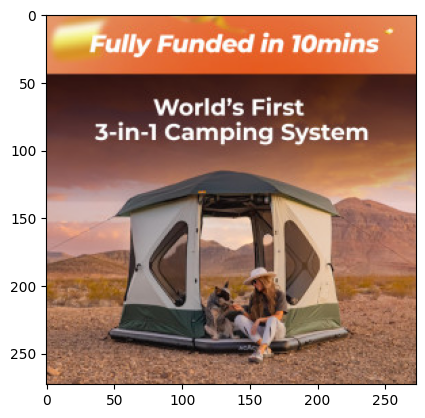

In [34]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('/content/images/img_1.jpg')
imgplot = plt.imshow(img)
plt.show()

In [35]:
import pandas as pd
ds_images = pd.DataFrame(list_images)
ds_images.set_index("project_id")
ds_images.head()

,project_id,img_file
0,https://www.indiegogo.com/projects/space-acaci...,img_1.jpg
1,https://www.indiegogo.com/projects/outpostx-an...,img_2.jpg
2,https://www.indiegogo.com/projects/core-one-th...,img_3.jpg
3,https://www.indiegogo.com/projects/phill-robot...,img_4.jpg
4,https://www.indiegogo.com/projects/fogo-junior...,img_5.jpg


In [36]:
ds_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   project_id  5 non-null      object
 1   img_file    5 non-null      object
dtypes: object(2)
memory usage: 208.0+ bytes


In [37]:
ds_images.to_csv("ds_images.csv")


In [38]:
!zip -r "/content/images.zip" "/content/images/"


  adding: content/images/ (stored 0%)
  adding: content/images/img_1.jpg (deflated 0%)
  adding: content/images/img_5.jpg (deflated 2%)
  adding: content/images/img_2.jpg (deflated 2%)
  adding: content/images/img_4.jpg (deflated 2%)
  adding: content/images/img_3.jpg (deflated 1%)


# API

Let's see how to use the **requests** library to hook APIs provided by our suppliers or colleagues.

## Crarifai

Let's try the services provided by Clarifai to increase the data we have available.


First, we need to install the `crarifai` python library.
For more details, please visit https://github.com/Clarifai/clarifai-python-grpc

To install the API client:


```
pip install clarifai-grpc
```






In [39]:
##############################################################################
# Installation
##############################################################################

!pip install clarifai-grpc --upgrade



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.8/206.8 kB 4.6 MB/s eta 0:00:00


In [40]:
##############################################################################
# Initialize client
##############################################################################

from clarifai_grpc.channel.clarifai_channel import ClarifaiChannel
from clarifai_grpc.grpc.api import resources_pb2, service_pb2, service_pb2_grpc
from clarifai_grpc.grpc.api.status import status_pb2, status_code_pb2

channel = ClarifaiChannel.get_grpc_channel()

# Note: You can also use a secure (encrypted) ClarifaiChannel.get_grpc_channel() however
# it is currently not possible to use it with the latest gRPC version

stub = service_pb2_grpc.V2Stub(channel)

# This will be used by every Clarifai endpoint call.
metadata = (('authorization', 'Key 05a84c8d24f44480bb93b289ac5a8e53'),)

We will use the `predict_by_filename` method to obtain the **concepts** within the page.


In [41]:
with open("/content/images/img_1.jpg", "rb") as f:
    file_bytes = f.read()

post_model_outputs_response = stub.PostModelOutputs(
    service_pb2.PostModelOutputsRequest(
        model_id="aaa03c23b3724a16a56b629203edc62c",
        inputs=[
            resources_pb2.Input(
                data=resources_pb2.Data(
                    image=resources_pb2.Image(
                        base64=file_bytes
                    )
                )
            )
        ]
    ),
    metadata=metadata
)

if post_model_outputs_response.status.code != status_code_pb2.SUCCESS:
    raise Exception("Post model outputs failed, status: " + post_model_outputs_response.status.description)


In [42]:
post_model_outputs_response

status {
  code: SUCCESS
  description: "Ok"
  req_id: "432888e208818cb92ac8d15a10256e50"
}
outputs {
  id: "0598cf51fecd420bb3d7dcd4b8ace7bb"
  status {
    code: SUCCESS
    description: "Ok"
  }
  created_at {
    seconds: 1686172132
    nanos: 390197523
  }
  model {
    id: "general-image-recognition"
    name: "Image Recognition"
    created_at {
      seconds: 1457543499
      nanos: 608845000
    }
    app_id: "main"
    model_version {
      id: "aa7f35c01e0642fda5cf400f543e7c40"
      created_at {
        seconds: 1520370624
        nanos: 454834000
      }
      status {
        code: MODEL_TRAINED
        description: "Model is trained and ready"
      }
      visibility {
        gettable: PUBLIC
      }
      app_id: "main"
      user_id: "clarifai"
      metadata {
      }
    }
    user_id: "clarifai"
    model_type_id: "visual-classifier"
    visibility {
      gettable: PUBLIC
    }
    modified_at {
      seconds: 1686079789
      nanos: 744367000
    }
    workflow_

What type of data does that give us back?
Let's have a look!

In [ ]:
# Since we have one input, one output will exist here.
output = post_model_outputs_response.outputs[0]

print("Predicted concepts:")
for concept in output.data.concepts:
    print("%s %.2f" % (concept.name, concept.value))

In [ ]:
output

Now let's go and identify all the concepts for each image of each project.

In [ ]:
ds_images = pd.read_csv("ds_images.csv", index_col="project_id")

img_details = []
for project_id, image in tqdm(ds_images.iterrows(), total=ds_images.shape[0]):
  try:
    with open('/content/images/' + image['img_file'], "rb") as f:
      file_bytes = f.read()
    response = stub.PostModelOutputs(
        service_pb2.PostModelOutputsRequest(
            model_id="aaa03c23b3724a16a56b629203edc62c",
            inputs=[
                resources_pb2.Input(
                    data=resources_pb2.Data(
                        image=resources_pb2.Image(
                            base64=file_bytes
                        )
                    )
                )
            ]
        ),
        metadata=metadata
    ).outputs[0]
    if(response.status.description == "Ok"):
      for concept in response.data.concepts:
          name = concept.name
          value = concept.value
          img_details.append({
            "project_id": project_id,
            "image": image['img_file'],
            "name": name,
            "value": value
          })
  except Exception as e:
    print(e)

print(len(img_details))

In [46]:
import pandas as pd
ds_img_details = pd.DataFrame(img_details)
ds_img_details.set_index("image")
ds_img_details.head()

,project_id,image,name,value
0,https://www.indiegogo.com/projects/space-acaci...,img_1.jpg,tent,0.997350
1,https://www.indiegogo.com/projects/space-acaci...,img_1.jpg,camper,0.994527
2,https://www.indiegogo.com/projects/space-acaci...,img_1.jpg,outdoors,0.993901
3,https://www.indiegogo.com/projects/space-acaci...,img_1.jpg,travel,0.970727
4,https://www.indiegogo.com/projects/space-acaci...,img_1.jpg,nature,0.968827


In [47]:
ds_img_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   project_id  100 non-null    object 
 1   image       100 non-null    object 
 2   name        100 non-null    object 
 3   value       100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.2+ KB


In [48]:
ds_img_details.to_csv('ds_img_details.csv')

# Geocoding

What's geocoding?



Let's try to geolocalize the projects...

In [49]:
import requests
import json
import pprint
import pandas as pd
from tqdm import tqdm_notebook as tqdm

address = "New Orleans, LA"
key = "r3xgNwBAviBMdOj4Op90kvyy2iO1CDGz"
geocode_url = f"http://www.mapquestapi.com/geocoding/v1/address?key={key}&location={address}"
response = requests.get(geocode_url)

import json
geo = json.loads(response.text)
pprint.pprint(response.text)

('{"info":{"statuscode":0,"copyright":{"text":"© 2022 MapQuest, '
 'Inc.","imageUrl":"http://api.mqcdn.com/res/mqlogo.gif","imageAltText":"© '
 '2022 MapQuest, '
 'Inc."},"messages":[]},"options":{"maxResults":-1,"ignoreLatLngInput":false},"results":[{"providedLocation":{"location":"New '
 'Orleans, '
 'LA"},"locations":[{"street":"","adminArea6":"","adminArea6Type":"Neighborhood","adminArea5":"New '
 'Orleans","adminArea5Type":"City","adminArea4":"Orleans","adminArea4Type":"County","adminArea3":"LA","adminArea3Type":"State","adminArea1":"US","adminArea1Type":"Country","postalCode":"","geocodeQualityCode":"A5XAX","geocodeQuality":"CITY","dragPoint":false,"sideOfStreet":"N","linkId":"0","unknownInput":"","type":"s","latLng":{"lat":29.9537,"lng":-90.07775},"displayLatLng":{"lat":29.9537,"lng":-90.07775},"mapUrl":""}]}]}')


In [50]:
print(geo['results'][0]['locations'][0]['latLng']['lat'])
print(geo['results'][0]['locations'][0]['latLng']['lng'])

29.9537
-90.07775


In [52]:
ds_projects = pd.read_csv("ds_project_details.csv", index_col="project_id")
ds_projects.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, https://www.indiegogo.com/projects/space-acacia-world-s-first-3-in-1-camping-system/pica to https://www.indiegogo.com/projects/sleeper-hold-a-travel-pillow-that-actually-works/pica
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  10 non-null     int64 
 1   backers     10 non-null     object
 2   goal        10 non-null     object
 3   left        10 non-null     object
 4   owner       9 non-null      object
 5   location    9 non-null      object
dtypes: int64(1), object(5)
memory usage: 560.0+ bytes


In [51]:
ds_projects = pd.read_csv("ds_project_details.csv", index_col="project_id")

import time
project_location = []
for project_id, project in tqdm(ds_projects.iterrows(), total=ds_projects.shape[0]):
  address = project['location']
  if(address is None):
    print(str(project_id) + "- " + project['location'])
  else:
    key = "r3xgNwBAviBMdOj4Op90kvyy2iO1CDGz"
    try:
      geocode_url = f"http://www.mapquestapi.com/geocoding/v1/address?key={key}&location={address}"
      response = requests.get(geocode_url)
      if(response.status_code == 200):
        geo = json.loads(response.text)
        lat = geo['results'][0]['locations'][0]['latLng']['lat']
        lng = geo['results'][0]['locations'][0]['latLng']['lng']
        project_location.append({
              "project_id": project_id,
              "lat": lat,
              "lng": lng
            })
    except Exception as e:
      print(e)
    

print(len(project_location))

<ipython-input-51-3cd33f501994>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for project_id, project in tqdm(ds_projects.iterrows(), total=ds_projects.shape[0]):


  0%|          | 0/10 [00:00<?, ?it/s]

10


In [53]:
import pandas as pd
ds_project_location = pd.DataFrame(project_location)
ds_project_location.set_index("project_id")
ds_project_location.head(20)

,project_id,lat,lng
0,https://www.indiegogo.com/projects/space-acaci...,40.73197,-74.17421
1,https://www.indiegogo.com/projects/outpostx-an...,37.89491,-113.65669
2,https://www.indiegogo.com/projects/core-one-th...,34.06457,-117.64810
3,https://www.indiegogo.com/projects/phill-robot...,25.96876,-80.14456
4,https://www.indiegogo.com/projects/fogo-junior...,48.85717,2.34140
5,https://www.indiegogo.com/projects/lilith-a-wh...,40.43851,-79.99734
6,https://www.indiegogo.com/projects/mother-brac...,35.65802,139.75155
7,https://www.indiegogo.com/projects/moonpass-lo...,34.73556,-77.99323
8,https://www.indiegogo.com/projects/cursed-wate...,36.20069,-115.12228
9,https://www.indiegogo.com/projects/sleeper-hol...,6.48812,2.61380


In [54]:
ds_project_location.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   project_id  10 non-null     object 
 1   lat         10 non-null     float64
 2   lng         10 non-null     float64
dtypes: float64(2), object(1)
memory usage: 368.0+ bytes


In [55]:
ds_project_location.to_csv('ds_project_location.csv')

# Use API to get data from Indiegogo

In [57]:
import sys
import logging
from selenium.webdriver.remote.remote_connection import LOGGER
LOGGER.setLevel(logging.WARNING)
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver

import requests
from tqdm import tqdm_notebook as tqdm
import pandas
import pprint
import pandas as pd
import json

In [58]:
project_list = []
for page in tqdm(range(1, 100)):
  payload = {"sort": "most_funded",
            "category_main": None,
            "category_top_level": "Creative Works",
            "project_timing": "all",
            "project_type": "campaign",
            "tags":[],
            "page_num": page,
            "per_page": 100,
            "q": ""}
  r = requests.post('https://www.indiegogo.com/private_api/discover',
                  headers={'Content-type': 'application/json; charset=UTF-8', "User-Agent": "curl/7.64.1"},
                  json=payload)
  my_projects = r.json()['response']['discoverables']
  project_list.extend(my_projects)

<ipython-input-58-9c74e1a89b9e>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for page in tqdm(range(1, 100)):


  0%|          | 0/99 [00:00<?, ?it/s]

In [59]:
len(project_list)

9900

In [60]:
print(project_list[0:2])

[{'bullet_point': None, 'category': 'Video Games', 'category_url': '/explore/video-games', 'clickthrough_url': '/projects/odin-the-ultimate-gaming-handheld', 'close_date': '2021-10-03T23:59:59-07:00', 'currency': 'HKD', 'funds_raised_amount': 32917148, 'funds_raised_percent': 49.40973, 'image_url': 'https://c1.iggcdn.com/indiegogo-media-prod-cld/image/upload/c_fill,f_auto,h_273,w_273/sdbglqsvgdtsiyorbo2i.jpg', 'is_indemand': False, 'is_pre_launch': False, 'is_promoted': False, 'is_proven': False, 'offered_by': None, 'open_date': '2021-08-19T00:00:00-07:00', 'perk_goal_percentage': None, 'perks_claimed': None, 'price_offered': None, 'price_retail': None, 'product_stage': None, 'project_id': 2685187, 'project_type': 'campaign', 'tagline': 'Flagship gaming handheld. FHD 1080p 6" touch screen. 6600 mAh battery.', 'tags': ['computers', 'pc', 'laptops'], 'title': 'Odin: The Ultimate Gaming Handheld'}, {'bullet_point': None, 'category': 'Video Games', 'category_url': '/explore/video-games', '

In [61]:
import pandas as pd
ds_detail_projects = pd.DataFrame(project_list)
ds_detail_projects.set_index("project_id")
ds_detail_projects.head()

,bullet_point,category,category_url,clickthrough_url,close_date,currency,funds_raised_amount,funds_raised_percent,image_url,is_indemand,...,perk_goal_percentage,perks_claimed,price_offered,price_retail,product_stage,project_id,project_type,tagline,tags,title
0,None,Video Games,/explore/video-games,/projects/odin-the-ultimate-gaming-handheld,2021-10-03T23:59:59-07:00,HKD,32917148,49.409730,https://c1.iggcdn.com/indiegogo-media-prod-cld...,False,...,NaN,NaN,None,None,None,2685187,campaign,"Flagship gaming handheld. FHD 1080p 6"" touch s...","[computers, pc, laptops]",Odin: The Ultimate Gaming Handheld
1,None,Video Games,/explore/video-games,/projects/g-case-all-in-one-gaming-case-for-sw...,2022-03-11T23:59:59-08:00,HKD,5473465,30.820762,https://c1.iggcdn.com/indiegogo-media-prod-cld...,False,...,NaN,NaN,None,None,None,2739227,campaign,Modular Battery | Interchangeable Grips | Deta...,"[bluetooth, batteries, design]",G-Case: All-In-One Gaming Case for Switch & OLED
2,None,Film,/explore/film,/projects/super-troopers-2,2015-04-24T23:59:59-07:00,USD,4617223,2.081839,https://c1.iggcdn.com/indiegogo-media-prod-cld...,False,...,NaN,NaN,None,None,None,1166581,campaign,"The #SuperTroopers2 campaign is over, but the ...",[other],Super Troopers 2
3,None,Writing & Publishing,/explore/writing-publishing,/projects/the-book-rebuilding-civilization,2021-01-04T23:59:59-08:00,USD,3210414,293.336625,https://c1.iggcdn.com/indiegogo-media-prod-cld...,True,...,NaN,NaN,None,None,None,2650630,campaign,The Ultimate Guide To Rebuilding A Civilizatio...,"[books, burning man, design, adventure, commun...",The Book - Rebuilding Civilization
4,None,Web Series & TV Shows,/explore/web-series-tv-shows,/projects/con-man,2015-04-10T23:59:59-07:00,USD,3156178,7.347459,https://c1.iggcdn.com/indiegogo-media-prod-cld...,False,...,NaN,NaN,None,None,None,1143140,campaign,A new comedy from Alan Tudyk and Nathan Fillio...,[other],Con Man


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument("user-agent=Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36")

In [ ]:
wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
import time
project_location = []
for project_id, project in tqdm(ds_detail_projects.iterrows(), total=ds_detail_projects.shape[0]):
  key = "r3xgNwBAviBMdOj4Op90kvyy2iO1CDGz"
  try:
    project_url = project["clickthrough_url"]
    wd.get(f"https://www.indiegogo.com/{project_url}")
    address = wd.find_elements(by=By.CSS_SELECTOR, value=".basicsCampaignOwner-details-city")[0].text
    geocode_url = f"http://www.mapquestapi.com/geocoding/v1/address?key={key}&location={address}"
    response = requests.get(geocode_url)
    if (response.status_code == 200):
      geo = json.loads(response.text)
      lat = geo['results'][0]['locations'][0]['latLng']['lat']
      lng = geo['results'][0]['locations'][0]['latLng']['lng']
      project_location.append({
            "project_id": project_id,
            "lat": lat,
            "lng": lng
          })
  except Exception as e:
    print(e)

In [ ]:
# project_location

In [ ]:
print(len(project_location))

In [ ]:
import pandas as pd
ds_project_location = pd.DataFrame(project_location)
ds_project_location.set_index("project_id")
ds_project_location.head(20)

In [ ]:
ds_project_location.to_csv("/content/drive/MyDrive/indiegogo_2022/2_ds_project_location_full.csv")

In [ ]:
!mkdir /content/drive/MyDrive/indiegogo_2022/images/

In [ ]:
detail_projects = []
list_images = []
num = 0
for project_id, project in tqdm(ds_detail_projects.iterrows(), total=ds_detail_projects.shape[0]):
  num = num + 1
  try:
    list_images.append({"project_id": project_id,
                        "img_file": "img_" + str(num) + ".jpg"})
    src = project['image_url']
    img_file = requests.get(src, stream=True)
    if img_file.status_code == 200:
      with open("/content/drive/MyDrive/indiegogo_2022/images/img_" + str(num) + ".jpg", 'wb') as f:
        f.write(img_file.content)
  except Exception as e:
    print(e)

In [ ]:
# list_images

In [ ]:
import pandas as pd
ds_images = pd.DataFrame(list_images)
ds_images.set_index("project_id")
ds_images.head()

In [ ]:
ds_images.to_csv("/content/drive/MyDrive/indiegogo_2022/3_ds_images_full.csv")

In [ ]:
# !pip install clarifai-grpc --upgrade

In [ ]:
from clarifai_grpc.channel.clarifai_channel import ClarifaiChannel
from clarifai_grpc.grpc.api import resources_pb2, service_pb2, service_pb2_grpc
from clarifai_grpc.grpc.api.status import status_pb2, status_code_pb2

channel = ClarifaiChannel.get_grpc_channel()

# Note: You can also use a secure (encrypted) ClarifaiChannel.get_grpc_channel() however
# it is currently not possible to use it with the latest gRPC version

stub = service_pb2_grpc.V2Stub(channel)

# This will be used by every Clarifai endpoint call.
metadata = (('authorization', 'Key 41a0bb727c0c462d8cd09aa359fa9649'),)

In [ ]:
!zip -r "/content/drive/MyDrive/indiegogo_2022/images_full.zip" "/content/drive/MyDrive/indiegogo_2022/images/"

In [ ]:
ds_images = pd.read_csv("/content/drive/MyDrive/indiegogo_2022/3_ds_images_full.csv", index_col="project_id")
ds_images.head()

In [ ]:

img_details = []
for project_id, image in tqdm(ds_images.iterrows(), total=ds_images.shape[0]):
  try:
    with open('/content/drive/MyDrive/indiegogo_2022/images/' + image['img_file'], "rb") as f:
      file_bytes = f.read()
    response = stub.PostModelOutputs(
        service_pb2.PostModelOutputsRequest(
            model_id="aaa03c23b3724a16a56b629203edc62c",
            inputs=[
                resources_pb2.Input(
                    data=resources_pb2.Data(
                        image=resources_pb2.Image(
                            base64=file_bytes
                        )
                    )
                )
            ]
        ),
        metadata=metadata
    ).outputs[0]
    print(response.status)
    if(response.status.description == "Ok"):
      for concept in response.data.concepts:
          name = concept.name
          value = concept.value
          img_details.append({
            "project_id": project_id,
            "image": image['img_file'],
            "name": name,
            "value": value
          })
  except Exception as e:
    print(e)

In [ ]:
# img_details

In [ ]:
import pandas as pd
ds_img_details = pd.DataFrame(img_details)
ds_img_details.set_index("image")
ds_img_details.head()

In [ ]:
ds_img_details.to_csv('/content/drive/MyDrive/indiegogo_2022/4_ds_img_details_full.csv')